## Process Visiopharm output

- 40 brains embedded, sectioned, stained, and mounted onto slides
- 8x5 grid per slide (n=8 conditions, n=5 per condition, n=5 stains), ~9000 sections
- GFAP and Iba1 = 210 um between slides; TH, TPH, and KOR = 420 um between slides
- brains were not embedded perfectly so there is some rostral-caudal variability (see example slide below)

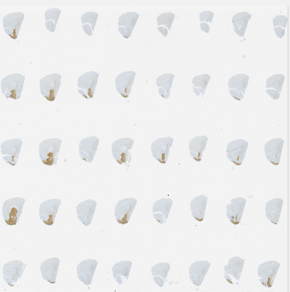

- train supervised ML algo to predict Allen Brain Atlas slide number
- Schindler lab reserach assistants labeled 400+ sections as training data

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics

import shap
# load JS visualization code to notebook
shap.initjs()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Create data frame

#### Get data

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/Section_210426.xlsx'

data = pd.read_excel(path)
data = pd.DataFrame(data = data)
print(data.shape)
print(data.columns)

data.head()

(3360, 13)
Index(['Measurement', 'Details', 'Section_OrientationV', 'Section_OrientationH', 'Section_MinorA', 'Section_MajorA', 'Section_Perimeter', 'Section_Ellipticalness', 'Section_Solidity', 'Section_Convexity', 'Section_FF', 'Section_Eccentricity', 'Section_Area'], dtype='object')


,Measurement,Details,Section_OrientationV,Section_OrientationH,Section_MinorA,Section_MajorA,Section_Perimeter,Section_Ellipticalness,Section_Solidity,Section_Convexity,Section_FF,Section_Eccentricity,Section_Area
0,TH_07,"(A, 1)",-0.227949,1.342847,2609.561035,5630.985352,16737.658203,0.705222,0.823447,0.852332,0.510678,0.714436,5027854.0
1,TH_07,"(A, 2)",-0.147365,1.423432,1879.806519,4013.249023,10199.124023,0.754694,0.968600,0.953224,0.687131,0.729109,5687338.0
2,TH_07,"(A, 3)",-0.172568,1.398228,1872.083252,4009.123291,10286.679688,0.832651,0.963591,0.943697,0.681761,0.730099,5744260.0
3,TH_07,"(A, 4)",-0.085375,1.485421,2212.127686,4214.876465,12105.322266,0.775587,0.946468,0.887583,0.605355,0.689320,7056723.0
4,TH_07,"(A, 5)",-0.022326,0.501273,2968.346924,6055.108887,20668.972656,0.738049,0.884669,0.816847,0.512606,0.673123,6106529.0


In [3]:
#fix TH measurement variables
#data['Measurement'] = [str('TH_' + str(x)) if len(str(x)) < 3 else x for x in data['Measurement']]
#add stain column
data['Stain'] = [x.split('_')[0] for x in data['Measurement'].values]
data['Slide'] = [x.split('_')[1] for x in data['Measurement'].values]
data['Letter'] = [x.split(',')[0].split('(')[1] for x in data['Details'].values]
data['Number'] = [int(x.split(',')[1].split(')')[0]) for x in data['Details'].values]

data.drop(['Measurement', 'Details'], axis=1, inplace=True)

print(data.shape)
data.head()

(3360, 15)


,Section_OrientationV,Section_OrientationH,Section_MinorA,Section_MajorA,Section_Perimeter,Section_Ellipticalness,Section_Solidity,Section_Convexity,Section_FF,Section_Eccentricity,Section_Area,Stain,Slide,Letter,Number
0,-0.227949,1.342847,2609.561035,5630.985352,16737.658203,0.705222,0.823447,0.852332,0.510678,0.714436,5027854.0,TH,07,A,1
1,-0.147365,1.423432,1879.806519,4013.249023,10199.124023,0.754694,0.968600,0.953224,0.687131,0.729109,5687338.0,TH,07,A,2
2,-0.172568,1.398228,1872.083252,4009.123291,10286.679688,0.832651,0.963591,0.943697,0.681761,0.730099,5744260.0,TH,07,A,3
3,-0.085375,1.485421,2212.127686,4214.876465,12105.322266,0.775587,0.946468,0.887583,0.605355,0.689320,7056723.0,TH,07,A,4
4,-0.022326,0.501273,2968.346924,6055.108887,20668.972656,0.738049,0.884669,0.816847,0.512606,0.673123,6106529.0,TH,07,A,5


In [4]:
data['Stain'].value_counts()

GFAP    2240
TH      1120
Name: Stain, dtype: int64

#### Get labels

In [5]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels'

dir_path_list = os.listdir(orig_path)

labels_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    labels_dir_paths.append(int_path)
    
labels_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit1.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Katrina.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Kathryn.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Omkar1.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Emma.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Saiyara.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/or

In [25]:
labels_final = pd.DataFrame()

for path in labels_dir_paths:
    print(path)
    if path.split('/')[-1] == '.DS_Store':
        pass 
    else:
        labels_int = pd.read_excel(path)
        labels_int = pd.DataFrame(data = labels_int)
        labels_int['name'] = path.split('/')[-1]
        print(labels_int.shape)
        print(labels_int.columns)
    
        if labels_final.shape[0] < 1:
            labels_final = labels_int
        else: 
            labels_final = pd.concat([labels_final, labels_int], axis=0)
    
    print(labels_final.shape, '\n')
    
labels_final.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/.DS_Store
(0, 0) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit1.xlsx
(40, 7)
Index(['Stain', 'Letter', 'Number', 'Slide_28', 'Slide_32', 'Slide_36', 'name'], dtype='object')
(40, 7) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Katrina.xlsx
(8, 17)
Index(['Stain', 'Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35', 'name'], dtype='object')
(48, 20) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Kathryn.xlsx
(40, 7)
Index(['Stain', 'Letter', 'Number', 'Slide_12', 'Slide_14', 'Slide_16', 'name'], dtype='object')
(88, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Wh

,Stain,Letter,Number,Slide_28,Slide_32,Slide_36,name,Slide_11,Slide_13,Slide_15,Slide_17,Slide_19,Slide_21,Slide_23,Slide_25,Slide_27,Slide_29,Slide_31,Slide_33,Slide_35,Slide_12,Slide_14,Slide_16,Slide_62,Slide_65,Slide_69,Slide_20,Slide_24,Slide_52,Slide_56,Slide_60,Slide_40,Slide_44,Slide_48
35,GFAP,H,1,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,76.0,85.0
36,GFAP,H,2,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,78.0,86.0
37,GFAP,H,3,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,80.0,88.0
38,GFAP,H,4,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,78.0,86.0
39,GFAP,H,5,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,81.0,89.0


In [26]:
#make tidy
slides = ['Slide_28', 'Slide_32', 'Slide_36',
          'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19',
       'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29',
       'Slide_31', 'Slide_33', 'Slide_35', 'Slide_12', 'Slide_14',
       'Slide_16', 'Slide_62', 'Slide_65', 'Slide_69', 'Slide_20',
       'Slide_24', 'Slide_52', 'Slide_56', 'Slide_60', 'Slide_40',
       'Slide_44', 'Slide_48']

labels_final_melt = pd.melt(labels_final, id_vars=['Stain', 'Letter', 'Number'], value_vars=slides,
              var_name='Slide', value_name='ABA_slide')

ABA_exclude = [19, '130-131']
labels_final_melt = labels_final_melt[~labels_final_melt['ABA_slide'].isin(ABA_exclude)]
labels_final_melt = labels_final_melt.replace({'none': np.nan})
labels_final_melt = labels_final_melt.dropna(axis=0)

#clean
labels_final_melt['Slide'] = [x.split('_')[1] for x in labels_final_melt['Slide']]
labels_final_melt['ABA_slide'] = [int(x) for x in labels_final_melt['ABA_slide']]                                                          

print(labels_final_melt.shape)
labels_final_melt.head()

(1229, 5)


,Stain,Letter,Number,Slide,ABA_slide
0,GFAP,A,1,28,51
1,GFAP,A,2,28,53
2,GFAP,A,3,28,53
3,GFAP,A,4,28,54
4,GFAP,A,5,28,55


In [27]:
#get count of aba slide labels, filter out anything with less than 5 data points
ABA_slide_count = labels_final_melt.groupby(['ABA_slide'])['ABA_slide'].count().reset_index(name='ABA_slide_count')
slides_keep = ABA_slide_count[ABA_slide_count['ABA_slide_count']>4]['ABA_slide'].values

labels_final_melt_clean = labels_final_melt[labels_final_melt['ABA_slide'].isin(slides_keep)]

print(labels_final_melt_clean.shape)
labels_final_melt_clean.head()

(1180, 5)


,Stain,Letter,Number,Slide,ABA_slide
0,GFAP,A,1,28,51
1,GFAP,A,2,28,53
2,GFAP,A,3,28,53
3,GFAP,A,4,28,54
4,GFAP,A,5,28,55


#### Combine

In [28]:
data_final = labels_final_melt.merge(data, on=['Stain', 'Letter', 'Number', 'Slide'], how='inner')
print(data_final.shape)
data_final.head()

(1229, 16)


,Stain,Letter,Number,Slide,ABA_slide,Section_OrientationV,Section_OrientationH,Section_MinorA,Section_MajorA,Section_Perimeter,Section_Ellipticalness,Section_Solidity,Section_Convexity,Section_FF,Section_Eccentricity,Section_Area
0,GFAP,A,1,28,51,-0.196294,1.374502,4139.737793,5223.416992,16402.705078,0.800326,0.976970,0.931831,0.761721,0.455484,16302510.0
1,GFAP,A,2,28,53,-0.176251,-0.176251,4517.102051,5547.178223,17686.011719,0.807682,0.991564,0.961013,0.748163,0.526874,18698934.0
2,GFAP,A,3,28,53,-0.216129,1.354667,4301.386719,5570.198242,16924.490234,0.838756,0.982946,0.945049,0.801409,0.477269,18269578.0
3,GFAP,A,4,28,54,-0.416947,1.153850,4197.537598,5563.500488,17147.636719,0.806784,0.978654,0.931684,0.756864,0.495502,17705234.0
4,GFAP,A,5,28,55,-0.365008,1.205788,4238.275391,5377.678223,16946.058594,0.793554,0.978093,0.923783,0.756678,0.460300,17286856.0


In [29]:
data_final['Stain'].value_counts()

TH      632
GFAP    597
Name: Stain, dtype: int64

### Explore features

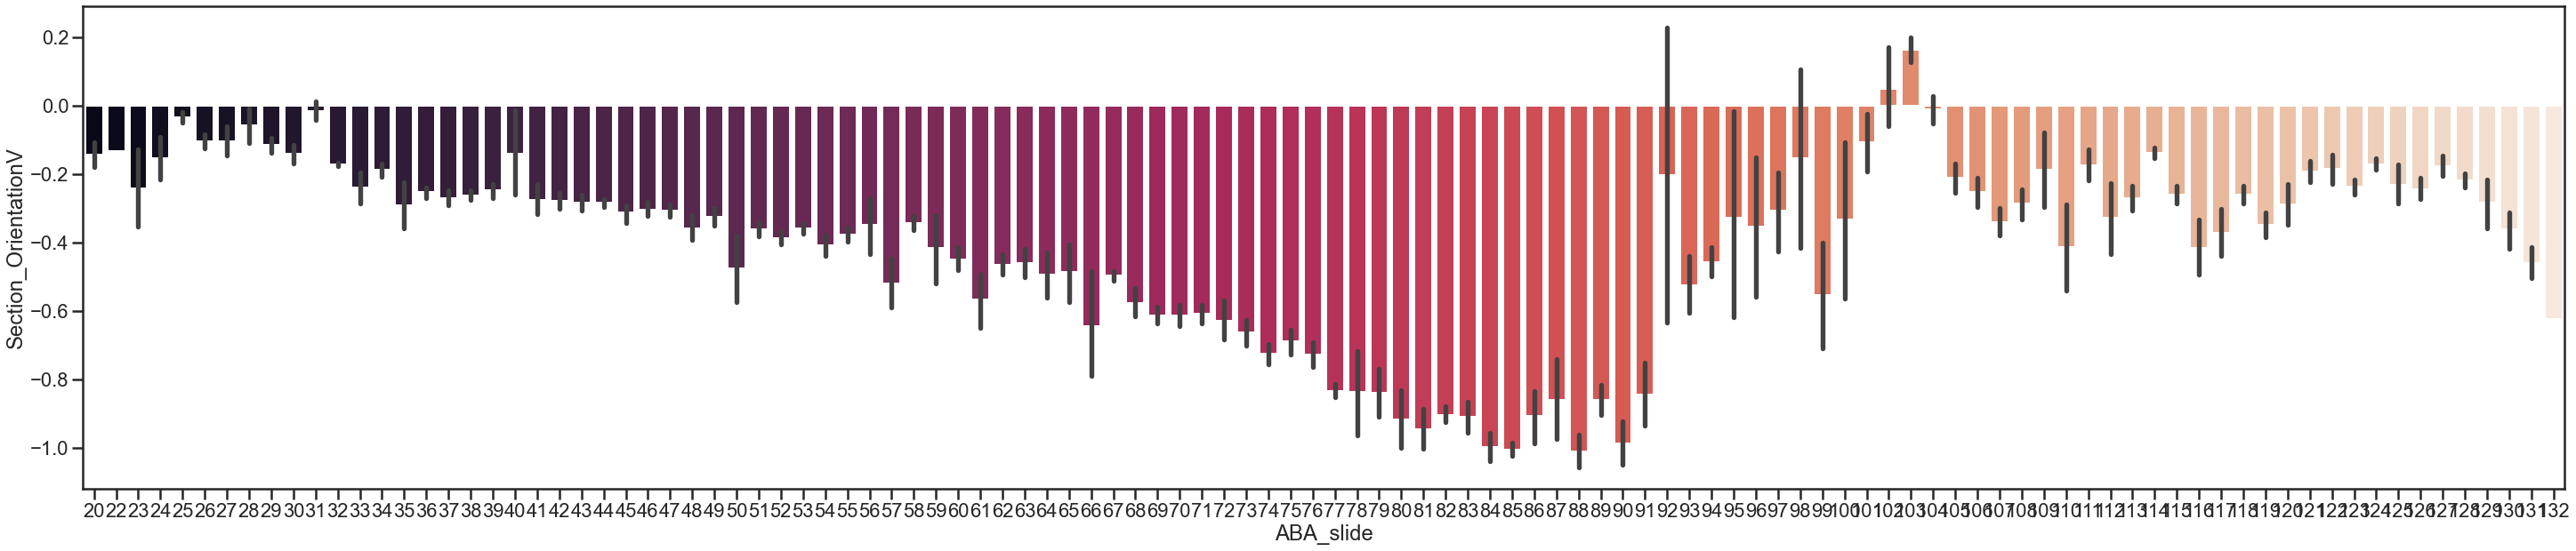

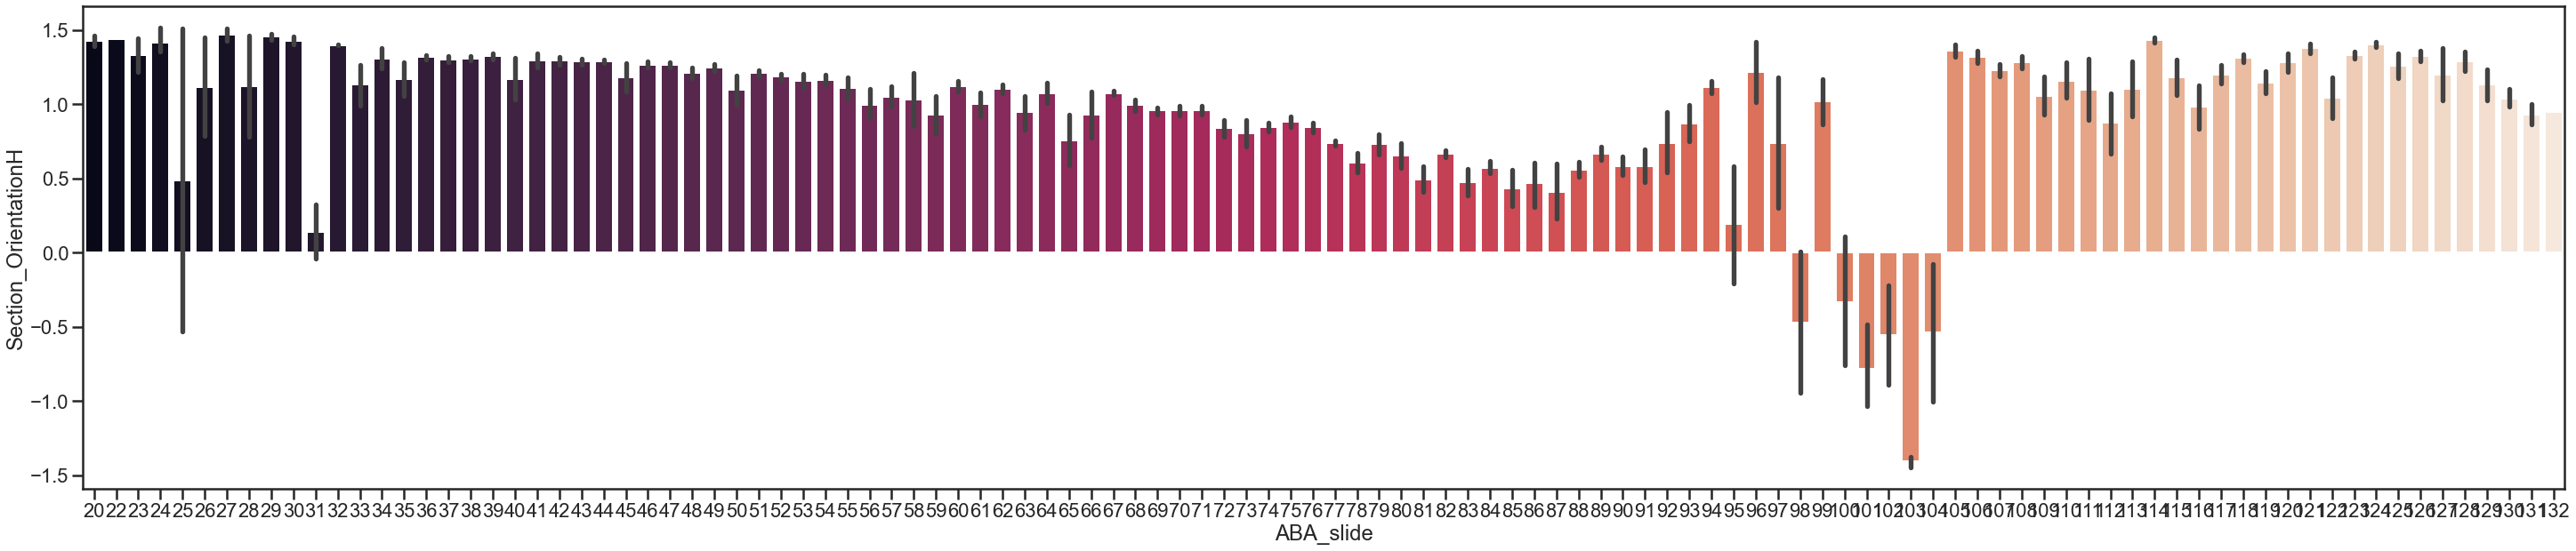

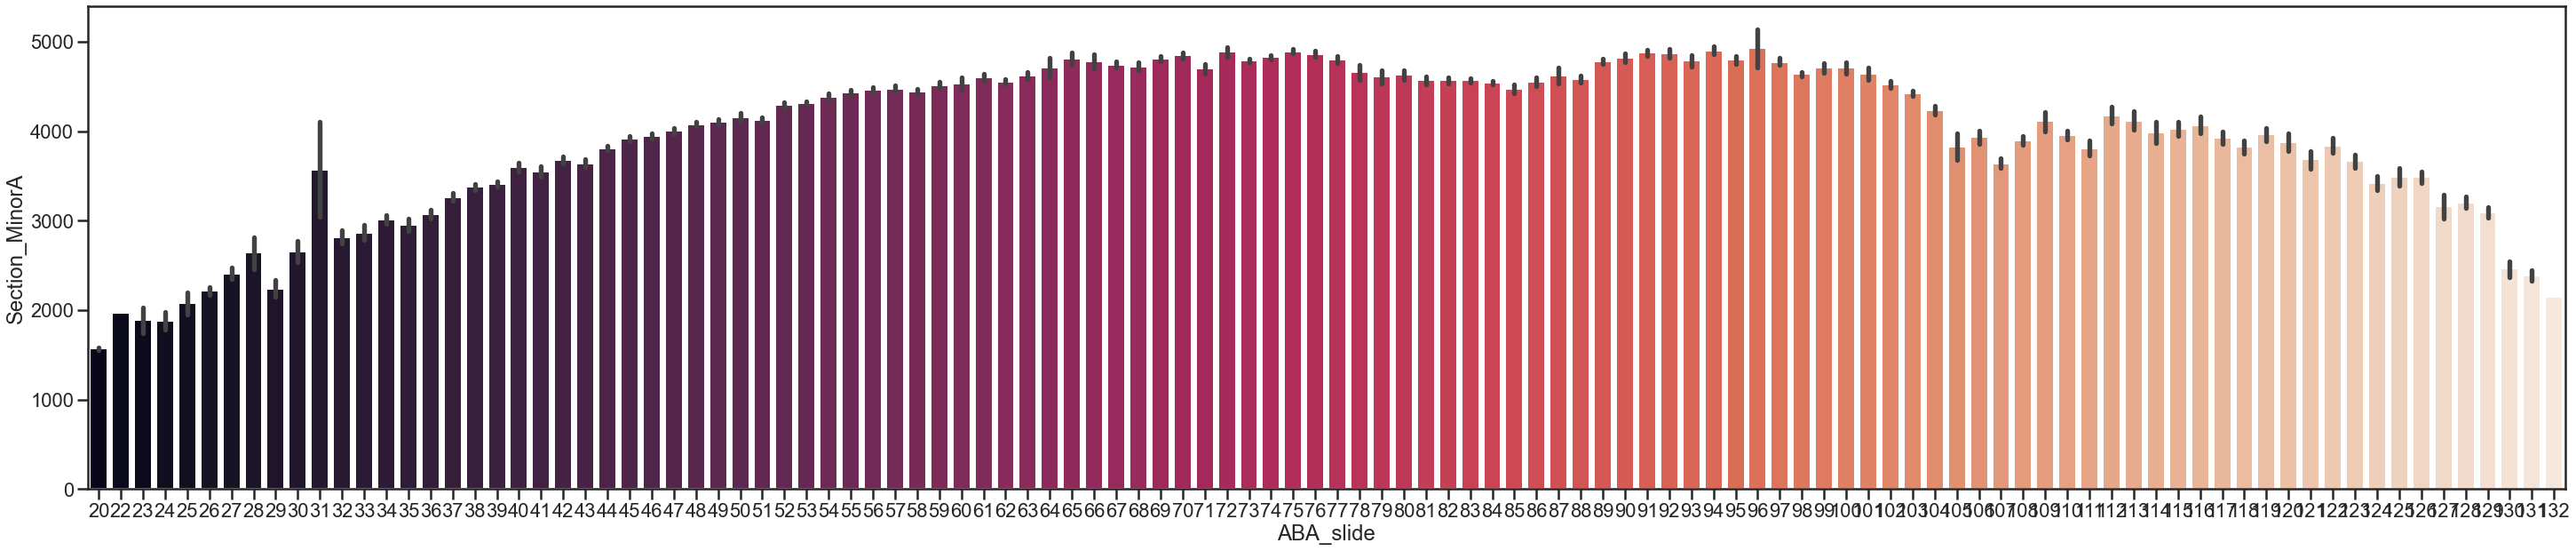

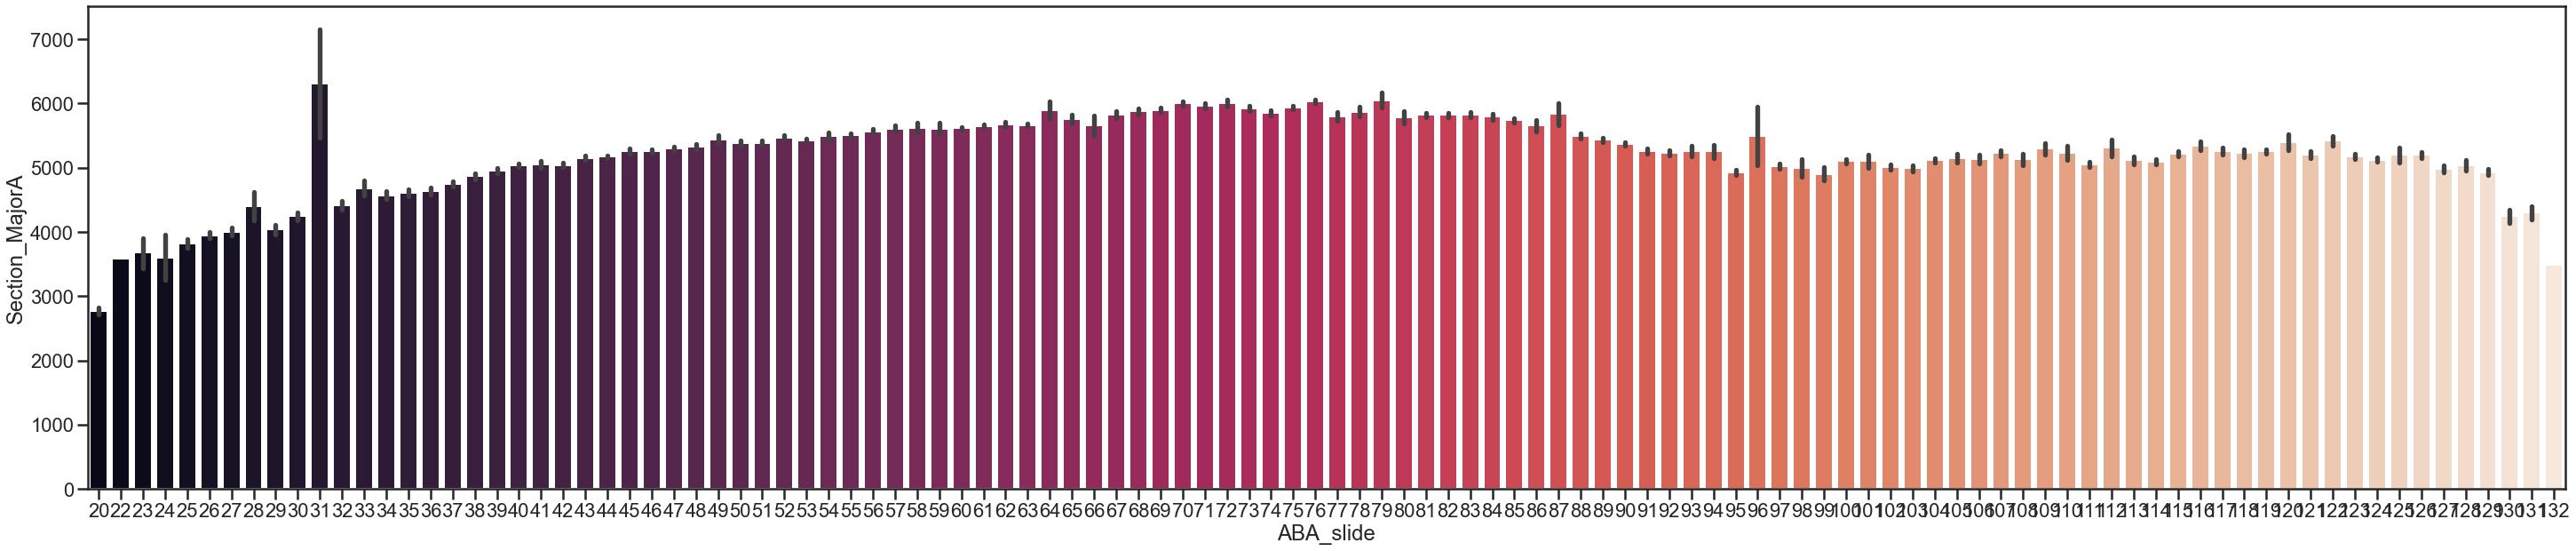

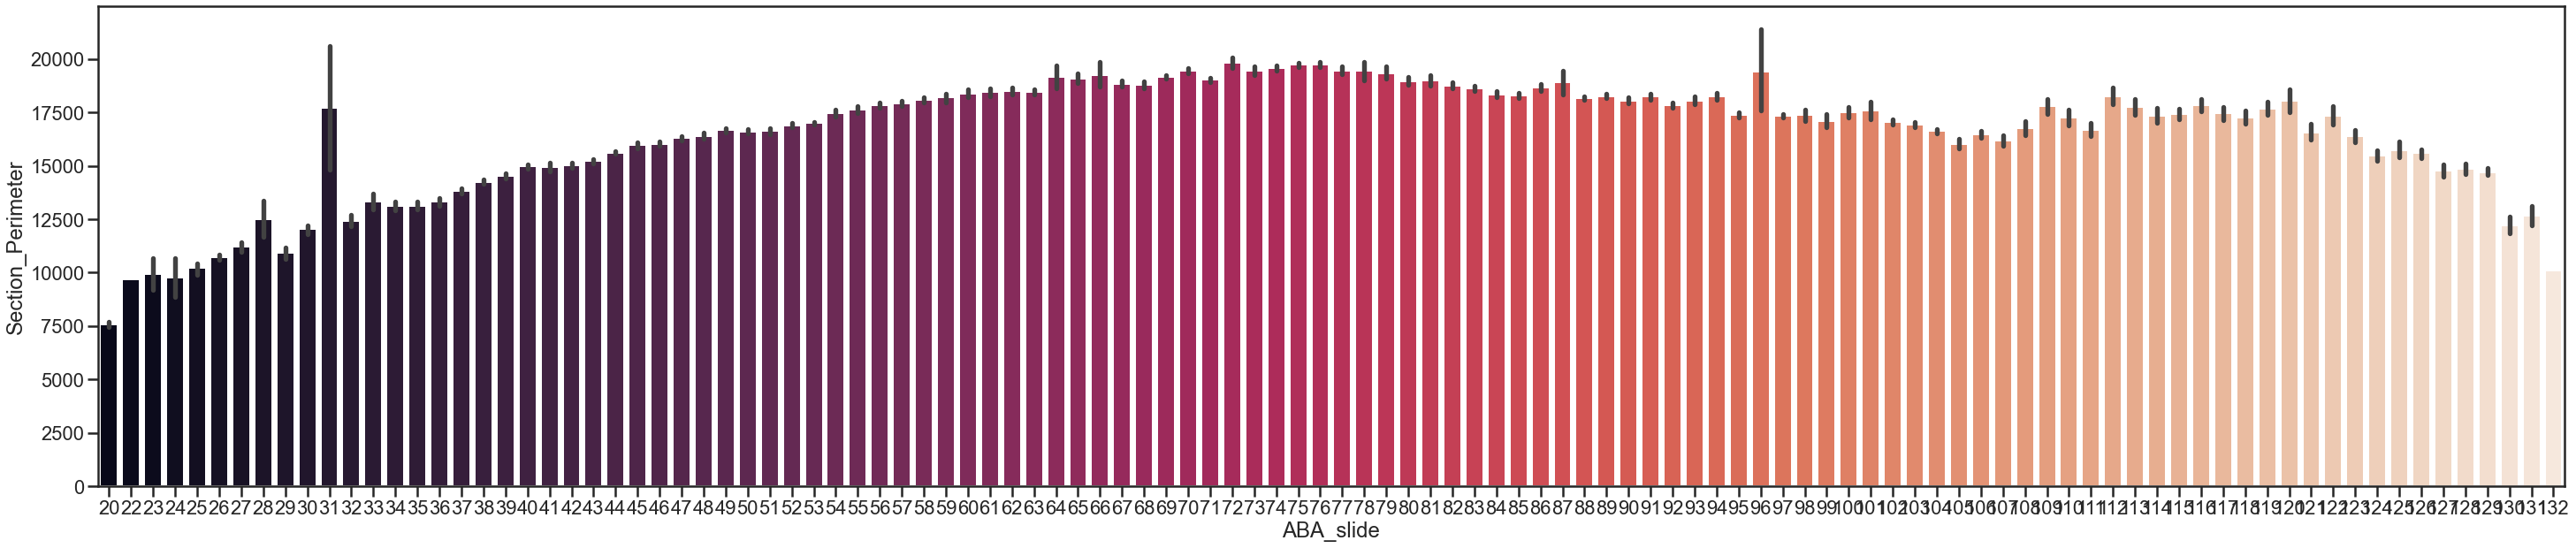

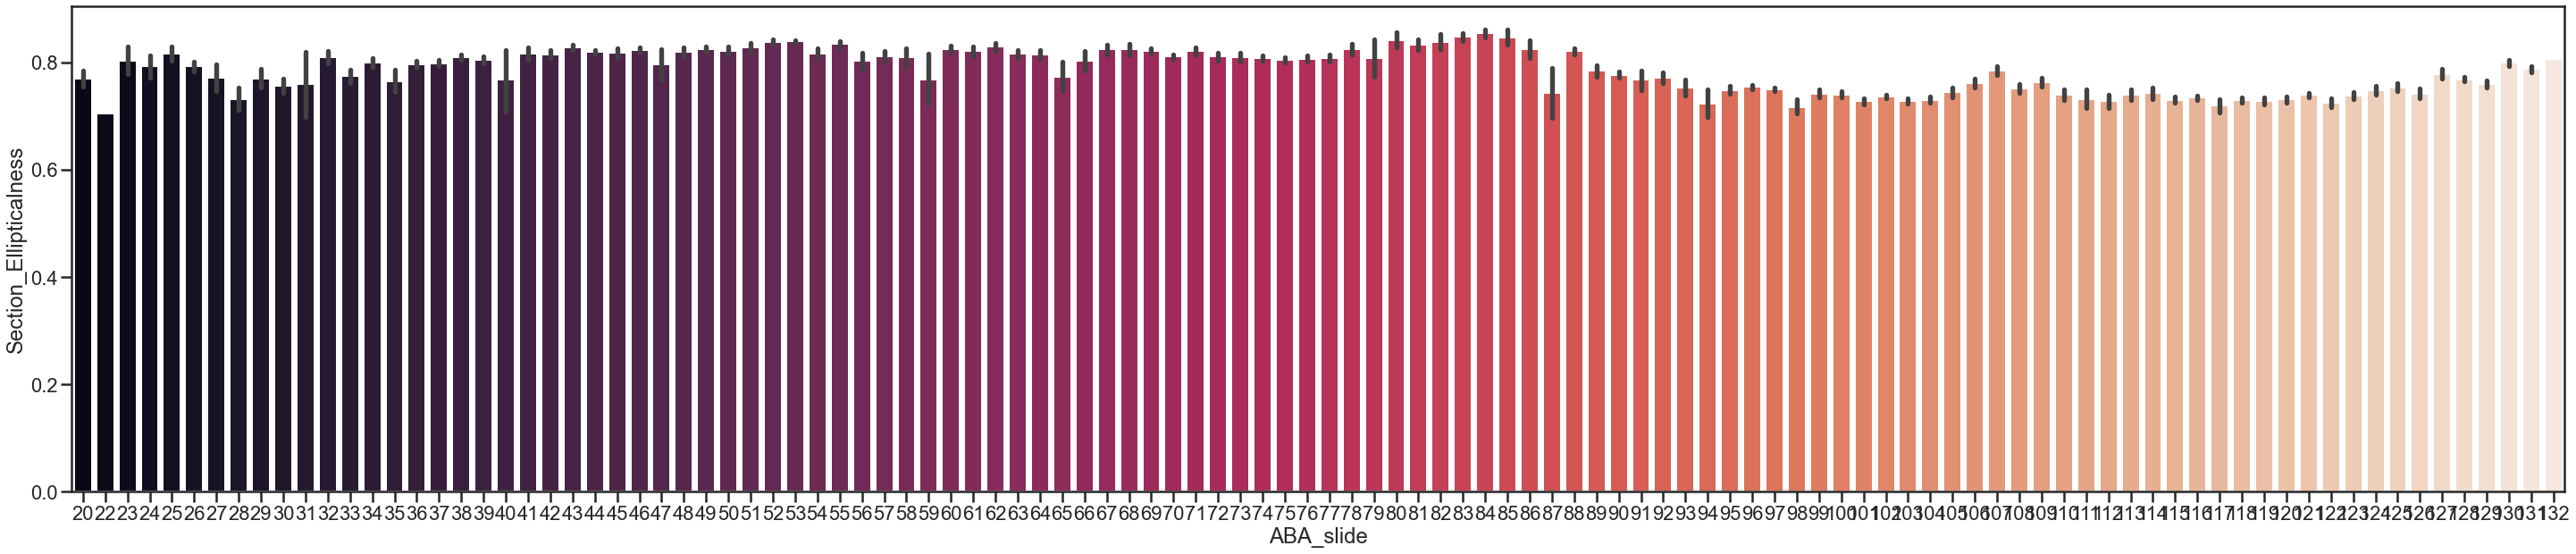

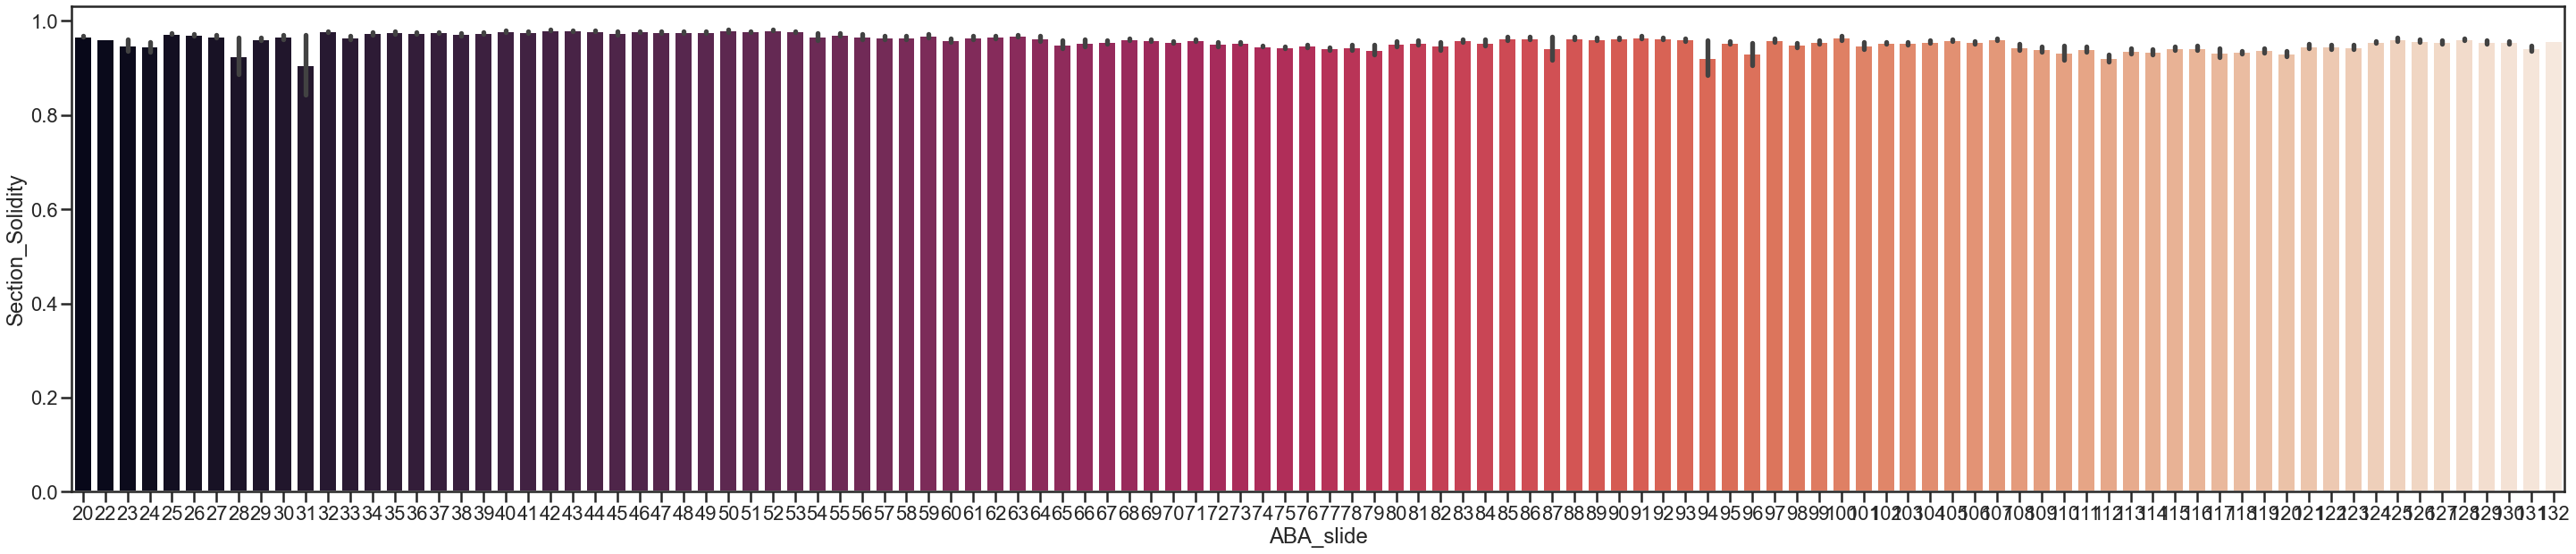

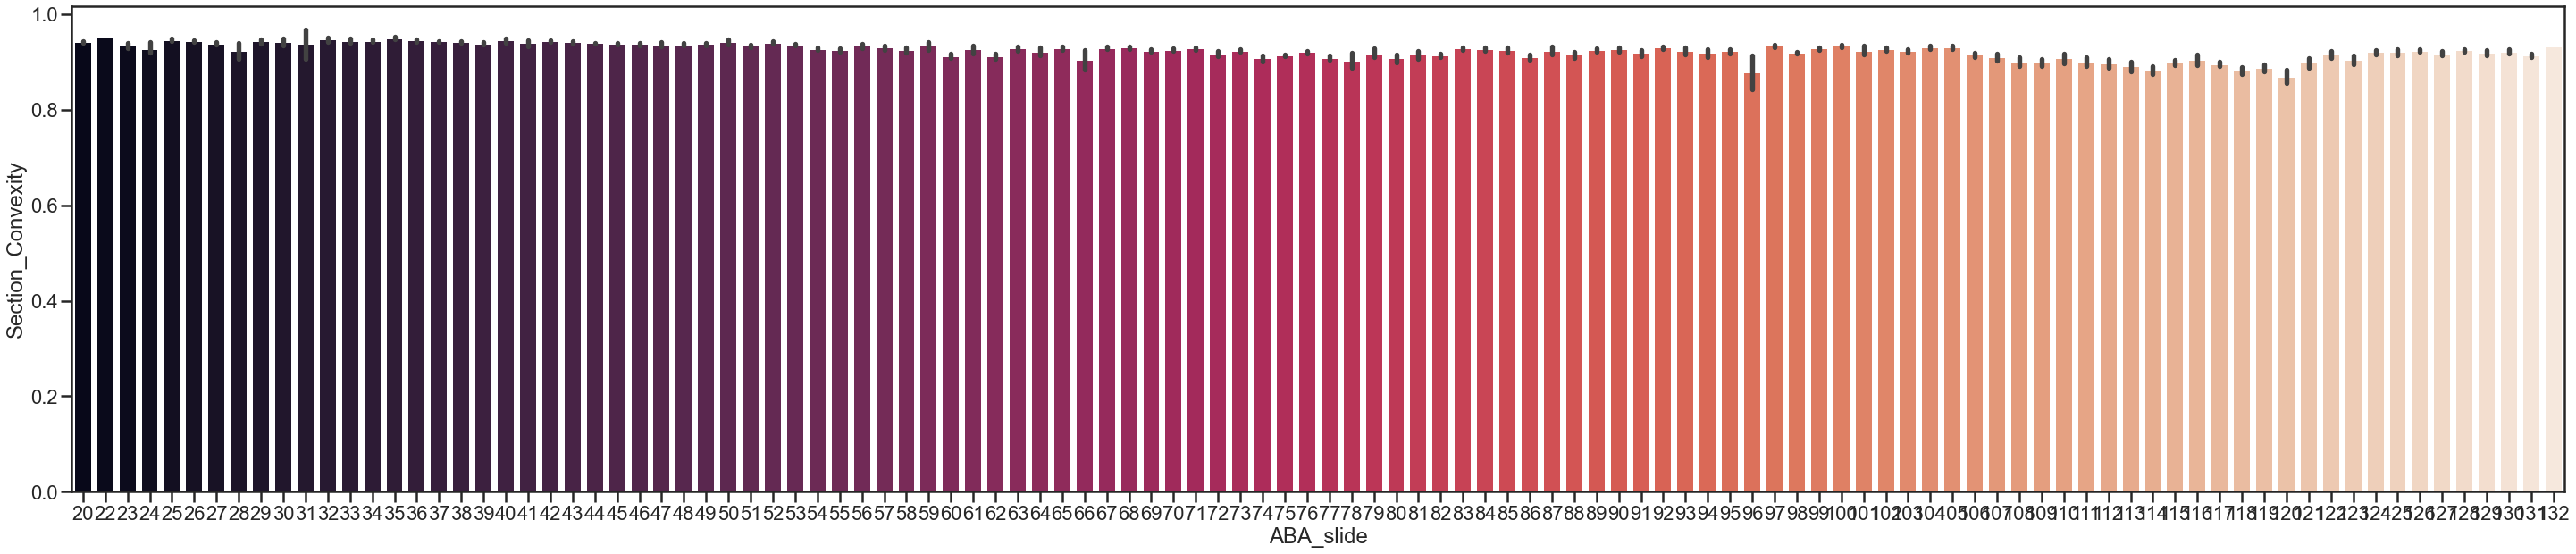

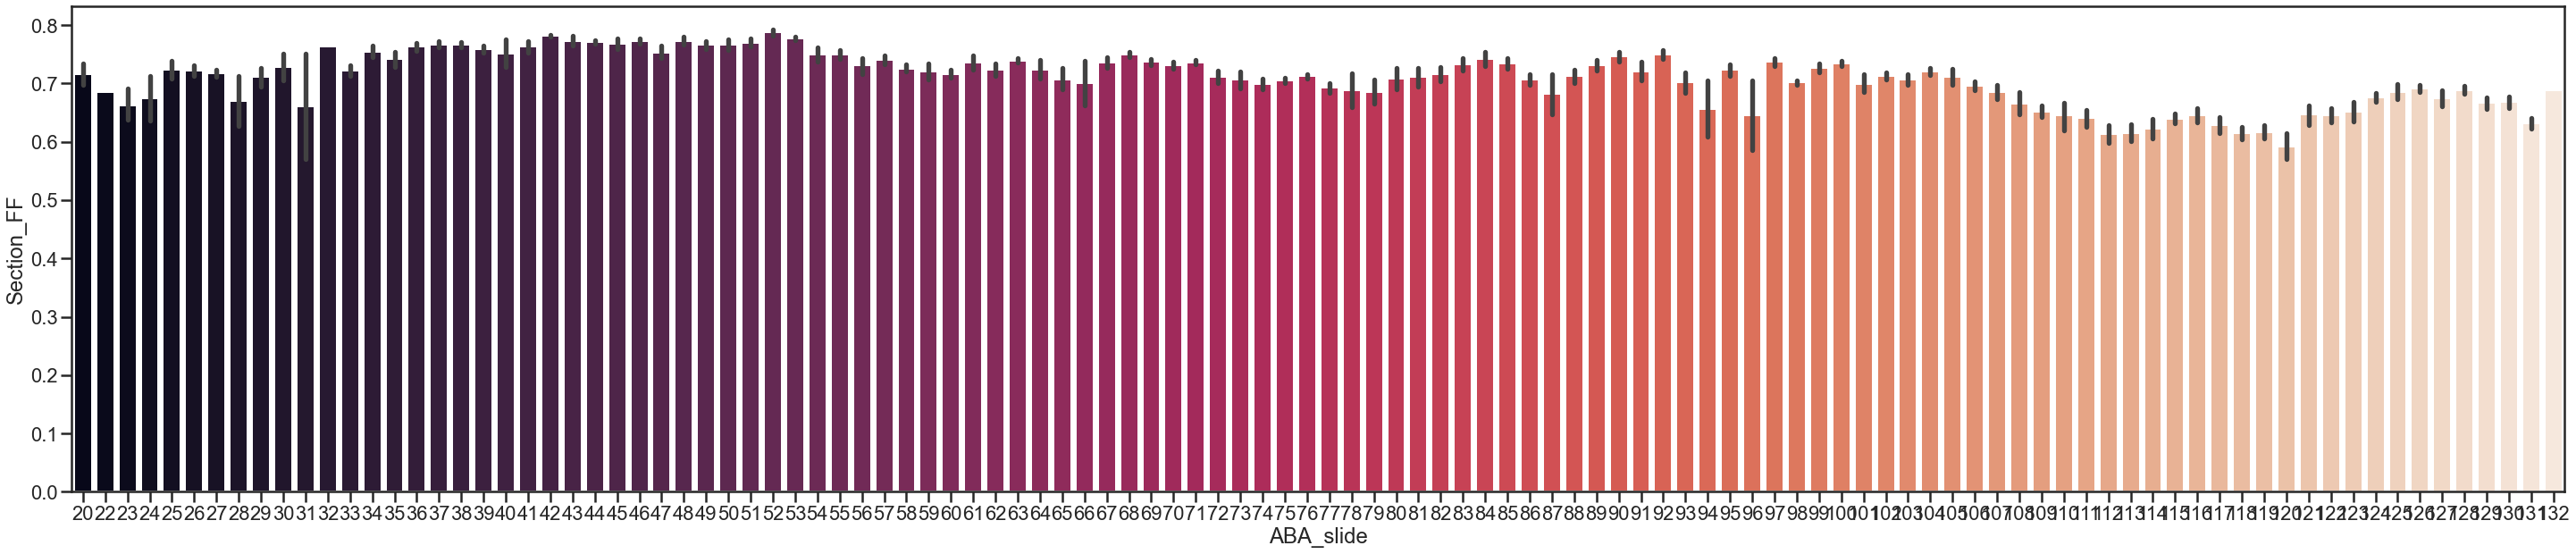

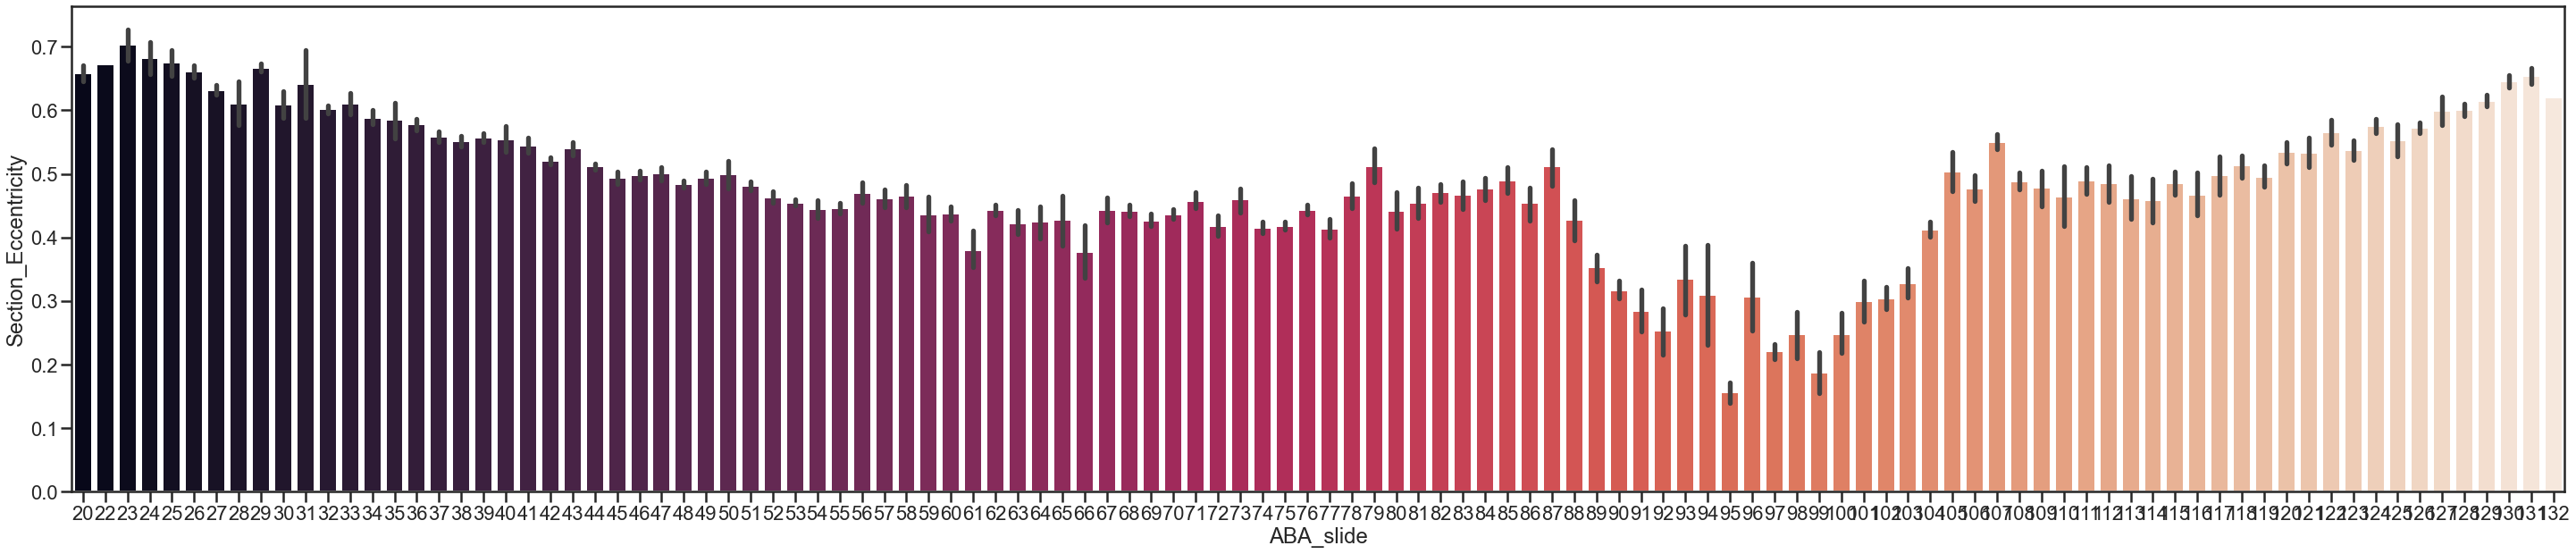

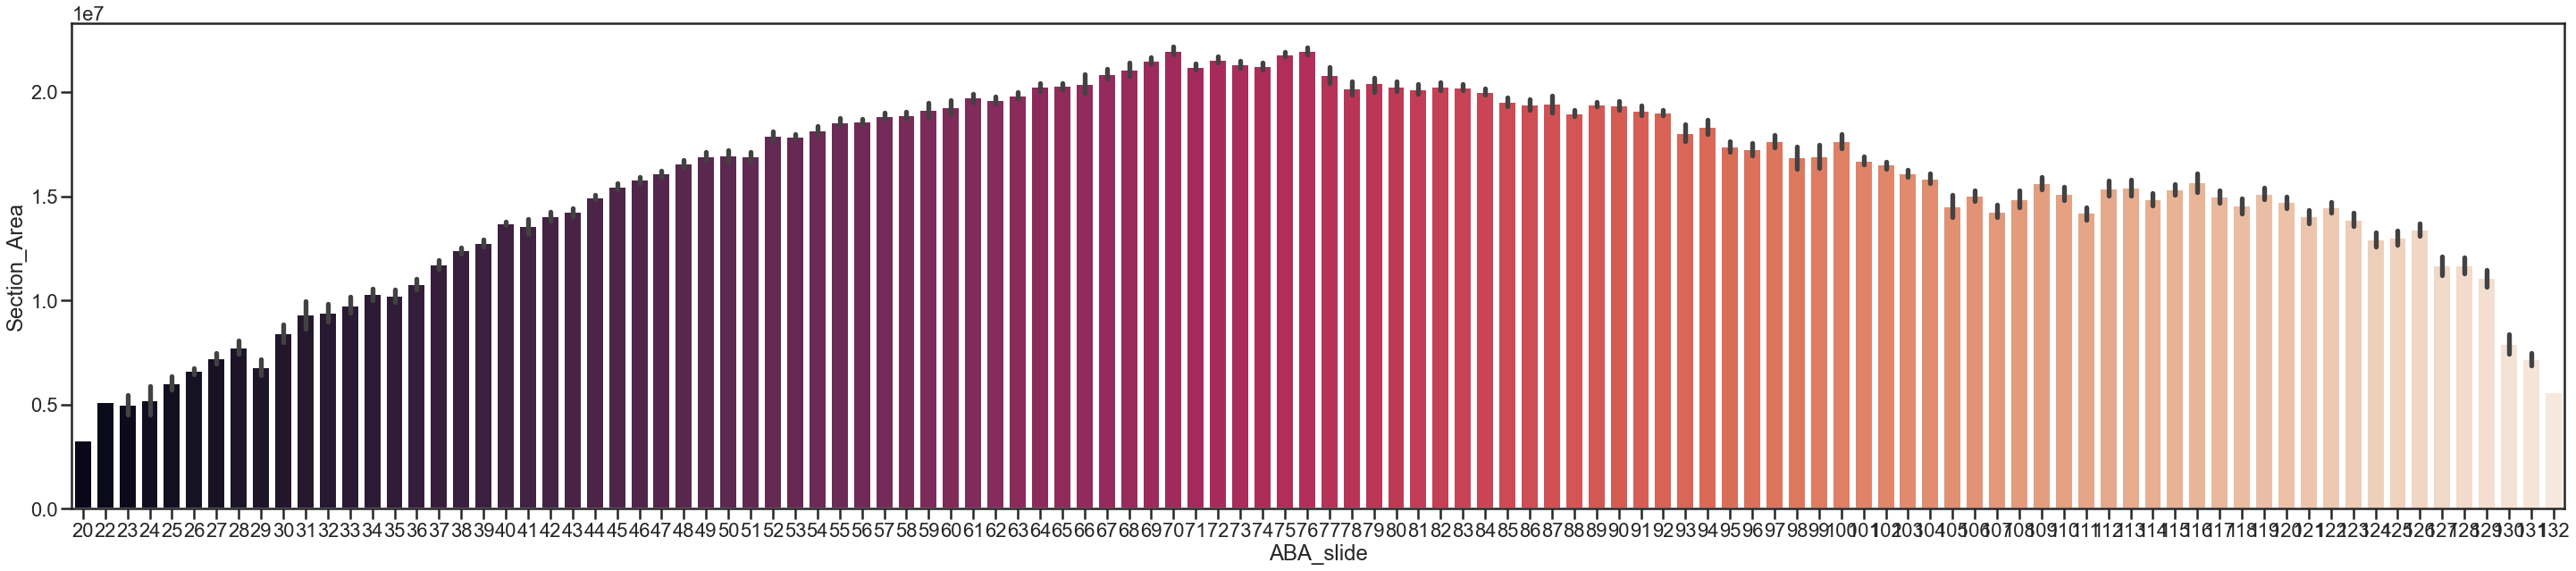

In [30]:
cols = ['Section_OrientationV', 'Section_OrientationH', 'Section_MinorA',
       'Section_MajorA', 'Section_Perimeter', 'Section_Ellipticalness',
       'Section_Solidity', 'Section_Convexity', 'Section_FF',
       'Section_Eccentricity', 'Section_Area']

for variable in cols:
    try:
        plt.figure(figsize=(50,10))
        g = sns.barplot(x='ABA_slide', y=variable, data=data_final, ci=68, palette="rocket")
        plt.show()
    except:
        pass

### Predict ABA slide number

In [48]:
data_predict = data_final.dropna().reset_index()
print(data_predict.shape)

#split data
train, test = train_test_split(data_predict, test_size = .3, random_state=39)

Y_train = train['ABA_slide']
Y_test = test['ABA_slide']

#create feature sets
features = ['Section_OrientationV', 'Section_OrientationH', 'Section_MinorA',
       'Section_MajorA', 'Section_Perimeter', 'Section_Ellipticalness',
       'Section_Solidity', 'Section_Convexity', 'Section_FF',
       'Section_Eccentricity', 'Section_Area']

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

(1229, 17)


In [49]:
#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

#classifier algos
dm = DummyRegressor()
lr = linear_model.LinearRegression()
rg = linear_model.Ridge()
rf = RandomForestRegressor(random_state=39)
knn = neighbors.KNeighborsRegressor()
bay = linear_model.BayesianRidge()
svr = svm.SVR()

In [50]:
#get model performance if we just use chance (e.g., 'dummy' model)
model = dm 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
mean_squared_error = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='neg_mean_absolute_error')
print('mean_squared_error = ', mean_squared_error.mean())
r2 = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='r2')
print('r2 = ', r2.mean())
explained_variance = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='explained_variance')
print('explained_variance = ', explained_variance.mean())

model.fit(train_scaled, Y_train)
print('\n')

#evaluate on test set
y_pred = model.predict(test_scaled)
print('r2 = ', metrics.r2_score(Y_test, y_pred))
print('explained_variance = ',metrics.explained_variance_score(Y_test, y_pred))
print('mean_absolute_error = ', metrics.mean_absolute_error(Y_test, y_pred))

mean_squared_error =  -28.129763836307916
r2 =  -0.002396398345383055
explained_variance =  1.1102230246251565e-16


r2 =  -0.00029135558250348303
explained_variance =  0.0
mean_absolute_error =  27.821188630490955


In [51]:
#best model performance is using k-nearest neighbors (KNN)
model = knn 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
mean_squared_error = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='neg_mean_absolute_error')
print('mean_squared_error = ', mean_squared_error.mean())
r2 = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='r2')
print('r2 = ', r2.mean())
explained_variance = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='explained_variance')
print('explained_variance = ', explained_variance.mean())

model.fit(train_scaled, Y_train)
print('\n')

#evaluate on test set
y_pred = model.predict(test_scaled)
print('r2 = ', metrics.r2_score(Y_test, y_pred))
print('explained_variance = ',metrics.explained_variance_score(Y_test, y_pred))
print('mean_absolute_error = ', metrics.mean_absolute_error(Y_test, y_pred))

mean_squared_error =  -6.8974418604651175
r2 =  0.7591792401226927
explained_variance =  0.761871201144061


r2 =  0.7502432041800362
explained_variance =  0.7505171890544758
mean_absolute_error =  7.326829268292682




Feature ranking:
1. feature 8 (0.362138)
2. feature 6 (0.131812)
3. feature 10 (0.131714)
4. feature 1 (0.083524)
5. feature 4 (0.069683)
6. feature 5 (0.062047)
7. feature 2 (0.042137)
8. feature 0 (0.031733)
9. feature 9 (0.030289)
10. feature 3 (0.030166)
11. feature 7 (0.024756)


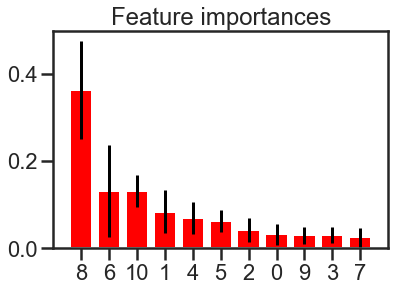

In [43]:
forest = rf
forest.fit(train_scaled, Y_train)
print('\n')

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

X = train_scaled
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [52]:
r2_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_scaled, Y_train)  #fit the model
    y_pred=model.predict(test_scaled) #make prediction on test set
    r2 = metrics.r2_score(Y_test, y_pred) #calculate r2
    r2_val.append(r2) #store r2 values
    print('r2 value for k= ' , K , 'is:', r2)

r2 value for k=  1 is: 0.6551238435220208
r2 value for k=  2 is: 0.738923027864091
r2 value for k=  3 is: 0.7314714739705434
r2 value for k=  4 is: 0.7526452032730078
r2 value for k=  5 is: 0.7502432041800362
r2 value for k=  6 is: 0.7611763435192149
r2 value for k=  7 is: 0.759484645849402
r2 value for k=  8 is: 0.7564546070721967
r2 value for k=  9 is: 0.7418618037381763
r2 value for k=  10 is: 0.7323643761389974
r2 value for k=  11 is: 0.7337612255349927
r2 value for k=  12 is: 0.7280883769128583
r2 value for k=  13 is: 0.7303047332798995
r2 value for k=  14 is: 0.729657569112323
r2 value for k=  15 is: 0.7219207177173806
r2 value for k=  16 is: 0.7114175131363251
r2 value for k=  17 is: 0.7173688014704295
r2 value for k=  18 is: 0.7147490480878904
r2 value for k=  19 is: 0.7103481897333559
r2 value for k=  20 is: 0.7068162072744426
r2 value for k=  21 is: 0.6995736207342089
r2 value for k=  22 is: 0.6999494447683849
r2 value for k=  23 is: 0.6929604863460667
r2 value for k=  24 is:

<AxesSubplot:>

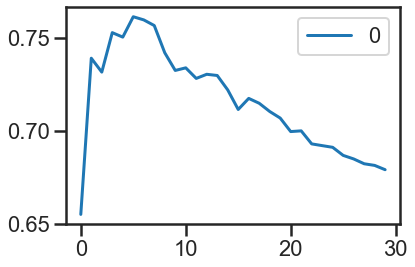

In [53]:
#plotting the rmse values against k values
curve = pd.DataFrame(r2_val) #elbow curve 
curve.plot()

In [54]:
model.fit(train_scaled, Y_train)
print('\n')

explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

Using 860 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/860 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X_train)